In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize
from scipy.integrate import trapz
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
def setup(filename):
    df = pd.read_csv(filename)
    df = df.fillna(method = 'ffill') # forward-filling all the NaNs
    spectra = df.loc[:, '0':'1023'] 
    array = spectra.to_numpy()
    spectrum = array.sum(axis = 0)
    x_all = np.array(range(0, 1024))
    y_all = spectrum
    plt.yscale('log')
    plt.plot(spectrum, '-r')
    plt.title('Full Spectrum')
    plt.show()
    return x_all, y_all

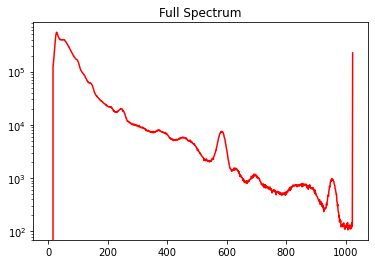

In [4]:
filename = '/home/akhila/Downloads/etch_roof_CesiumIodide.csv'
x, y = setup(filename)

In [5]:
params = {'p0':[3000, 0.05], 'amp':1000, 'x0':955, 'sigma':0.6, 'a': 2, 'b':2}
# create a dictionary of p0, a, b, amp, x0, and sigma

In [6]:
# integration method

def arguments (**keywordargs): # seperating p0 and gaussian kwargs 
    p0 = keywordargs['p0']
    gauss_guess = []
    a = keywordargs['a']
    if a == None:
        a = 1
        gauss_guess.append(a)
    else:
        gauss_guess.append(keywordargs['a'])
    b = keywordargs['b']
    if b == None:
        b = 1
        gauss_guess.append(b)
    else:
        gauss_guess.append(keywordargs['b'])
    gauss_guess.append(keywordargs['amp'])
    gauss_guess.append(keywordargs['x0'])
    gauss_guess.append(keywordargs['sigma'])
    return  p0, gauss_guess

def gaussian(x, amp, x0, sigma):
    return amp*np.exp(-(x-x0)**2/(2*sigma**2))

def gaussian_function(x, a, b, amp, x0, sigma): 
    return (x*a + b + gaussian(x, amp, x0, sigma))

def NetCounts_integration(x, y, xbounds_left, xbounds_right, **kwargs):
    '''
    Returns net counts of given peak using Gaussian integration.
    
        Parameters:
            x (array): x values
            y (array): y values
            xbounds_left (int): left bound of peak
            xbounds_right (int): right bound of peak
            Keyword arguments:
            p0 (list): estimate values for exponential curve fit
            amp (int): amplitude of peak
            x0 (int): mean of distribution
            sigma (float): sigma (variance) value
            a (int), Optional: estimate value for base; defaults to 1
            b (int), Optional: estimate value for base; defaults to 1
            
        Returns:
            integrated (float): Net counts as determined by Gaussian integration
    '''
    
    xpeak = x[xbounds_left:xbounds_right] 
    ypeak = y[xbounds_left:xbounds_right] 
    
    p0, gauss_guess = arguments(**kwargs)
    

    popt, pcov = scipy.optimize.curve_fit(gaussian_function, xpeak, ypeak, gauss_guess)

    gauss_vals = gaussian(xpeak, *popt[-3:]) # gaussian fit values

    plt.figure(figsize = (10, 6)) 
    plt.plot(xpeak, ypeak, label="data")
    plt.plot(xpeak, gauss_vals, '-y', label = 'Gaussian') 
    plt.legend()
    plt.title("Gaussian Integration")
    plt.grid()
    plt.legend()
    plt.show()

    # integrating
    integrated = gauss_vals.sum()
    print('Net counts:', integrated)
    
    return integrated

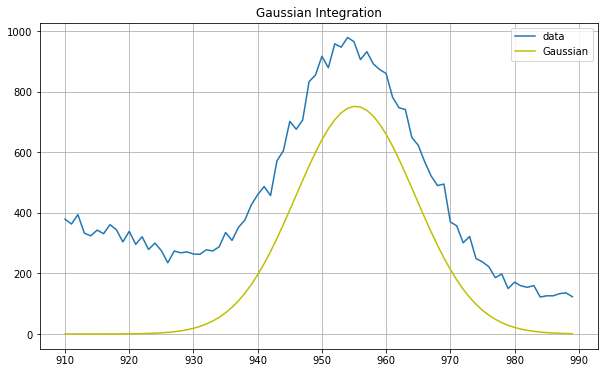

Net counts: 17504.21875021408


17504.21875021408

In [7]:
NetCounts_integration(x,y, 910, 990, **params)

In [8]:
params = {'p0':[1000, 0.05], 'offset':None, 'tail length':0.46}
# Note: if curve fit is underestimating drastically, try reducing tail length
#       if curve fit is overestimating drastically, try increasing tail length

[4.35208216e+04 4.83726184e-03]
[ 102  103  104  105  106  107  108  109  110  111  112  113  114  115
  116  117  118  119  120  121  122  123  124  125  126  127  128  129
  130  131  132  133  134  135  136  137  138  139  140  141  142  143
  144  145  146  147  148  149  150  151  152  153  154  155  156  157
  158  159  160  161  162  163  164  165  166  167  168  169  170  171
  172  173  174  175  176  177  178  179  180  181  182  183  184  185
  186  187  188  189  190  191  192  193  194  195  196  197  198  199
  200  201  202  203  204  205  206  207  208  209  210  211  212  213
  214  215  216  217  218  219  220  221  222  223  224  225  226  227
  228  229  230  231  232  233  234  235  236  237  238  239  240  241
  242  243  244  245  246  247  248  249  250  251  252  253  254  255
  256  257  258  259  260  261  262  263  264  265  266  267  268  269
  270  271  272  273  274  275  276  277  278  279  280  281  282  283
  284  285  286  287  288  289  290  291  292

/tmp/ipykernel_114315/4009430835.py:14: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * x)


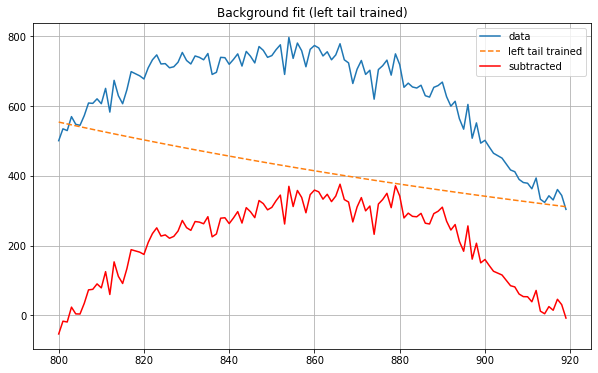

Net counts (tail-trained background): 25676.10312889503


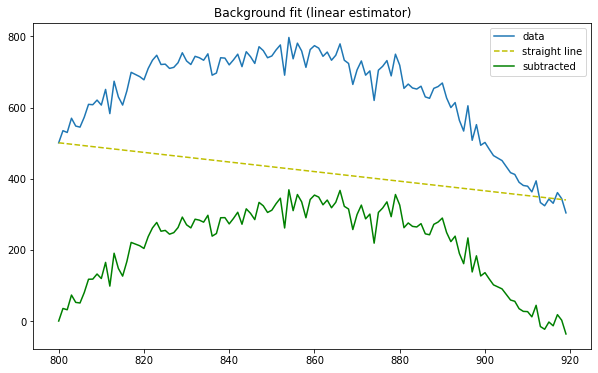

Coefficients: [-1.350e+00  1.581e+03]
Net counts (linear-estimate background): 25770.174999999952


(25676.10312889503, 25770.174999999952)

In [13]:
# Using background subtraction 

def seperate_args (**keywordargs): # seperating p0 and gaussian kwargs 
    p0 = keywordargs['p0']
    offset = keywordargs['offset']
    if offset == None:
        offset = 0.1
    tail_length = keywordargs['tail length']
    if tail_length == None:
        tail_length = 0.25
    return p0, offset, tail_length

def exponential_curve(x, m, t): 
    return m * np.exp(-t * x)

def NetCounts_subtraction(x, y, xbounds_left, xbounds_right, **kwargs):
    '''
    Uses two approaches to subtract background counts and return net counts of given peak.
    
        Parameters:
            x (array): x values
            y (array): y values
            xbounds_left (int): left bound of peak
            xbounds_right (int): right bound of peak
            Keyword arguments:
            p0 (list): estimate values for exponential curve fit
            offset (float), Optional: percentage of offset to avoid noise early in data; defaults to 0.1
            tail length (float), Optional: percentage of data to use as tail; defaults to 0.25
            
        Returns:
            tailBackground_subtracted(float): Net counts as determined by tail-trained background subtraction 
            straightBackground_subtracted(float): Net counts as determined by subtracting a straight line between bounds
    '''
    
    p0, offset, tail_length = seperate_args(**kwargs)

    tail_length = (len(x)*float(tail_length)) 
    tail_length = int(tail_length)
         
    tail_bound = xbounds_left-tail_length # identifying the left tail    
    x_roi = x[tail_bound:xbounds_right] 
    y_roi = y[tail_bound:xbounds_right] # includes left tail and peak
    
    # training the curve on the left tail 
    leftx = x[tail_bound:xbounds_left] # left tail
    lefty = y[tail_bound:xbounds_left]
    left_p, left_c = scipy.optimize.curve_fit(exponential_curve, leftx, lefty, p0, maxfev = 1000000)
    
    
    # didn't use right-tail or two-tail training because of sensor settling noise
   
    offset = len(x)*float(offset) # to avoid noise early in the data
    offset = int(offset)
    
    left_tail = exponential_curve(x[offset:], left_p[0], left_p[1])
    print(left_p)
    print(x[offset:])
    xpeak = x[xbounds_left:xbounds_right] # peak only
    ypeak = y[xbounds_left:xbounds_right]
    print(len(left_tail))
    plt.figure(figsize = (10, 6))
    plt.plot(xpeak, ypeak, label="data")
    plt.plot(xpeak, left_tail[xbounds_left:xbounds_right], '--', label="left tail trained") # peak with left tail trained curve
    plt.plot(xpeak, ypeak - left_tail[xbounds_left:xbounds_right], '-r', label = 'subtracted') # peak with curve subtracted
    plt.legend()
    plt.title("Background fit (left tail trained)")
    plt.grid()
    plt.legend()
    plt.show()
    
    # area under curve, tail-trained background subtracted 
    tailBackground_subtracted = scipy.integrate.trapz((ypeak - left_tail[xbounds_left:xbounds_right]), xpeak)
    print('Net counts (tail-trained background):', tailBackground_subtracted)
    
    # depending on data, left tail training may be inaccurate
    # option for a straight line between bounds as background fit
    x1 = [x[xbounds_left], x[xbounds_right]]
    y1 = [y[xbounds_left], y[xbounds_right]]
    coefs = np.polyfit(x1, y1, 1)
    poly = np.poly1d(coefs) 
    straight_y = poly(xpeak)
    plt.figure(figsize = (10, 6))
    plt.plot(xpeak, ypeak, label="data")
    plt.plot(xpeak, straight_y, 'y--', label ='straight line')
    plt.plot(xpeak, ypeak-straight_y, '-g', label = 'subtracted')
    plt.legend()
    plt.title('Background fit (linear estimator)')
    plt.show()
    print('Coefficients:', coefs)

    # area under curve, straight background subtracted
    straightBackground_subtracted = scipy.integrate.trapz((ypeak-straight_y), xpeak)
    print('Net counts (linear-estimate background):', straightBackground_subtracted)
    return tailBackground_subtracted, straightBackground_subtracted

NetCounts_subtraction(x, y, 800, 920, **params) 
